# Project-1-Spotify

We are a consulting company for independent artists. We are helping a new Mexican artist to launch their next hit in Mexico and Latin America, which is planned to be released in last quarter 2020 in the Spotify platform, to remain in the Top 50 Chart throughout the next year.

Tasks:

* Identify most popular music genres in the population segment that the artist is targeting.
* Identify patterns in the tempo, energy, danceability and acousticness of the music that people in that segment listen to in different quarters.
* Define the properties that the artist's song should have to be succesful in last quarter 2020 in Mexico and Latin America.
* Predict how popular this song will be in upcoming quarters.


## Data preparation

In [1]:
#Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
import csv

#Import Top 50 chart and Stats table. Get track ID from URL.
top50_chart_df = pd.read_excel("chartmx_03_20.xlsx", index = False)
stats_df = pd.read_excel("audiofmx.xlsx", index = False)

top50_chart_df["id"] = top50_chart_df["URL"].str[-22:]


In [2]:
#Select columns from both Data Frames
top50_chart_df = top50_chart_df[["Position", "Track Name", "Artist", "Date", "id"]]
stats_df = stats_df[["acousticness", "danceability", "duration_ms", "energy", "id", "instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature", "type", "valence"]]

In [3]:
#Import genre data set from 'tsv' file as list.
genres_tsv = os.path.join("songDb.tsv")
with open(genres_tsv, "r") as csvfile:
    csvreader = csv.reader(csvfile, delimiter = "\t")
    genres_data = list(csvreader)

#Remove empty rows from original list.
genres_data_clean = []
for element in genres_data:
    if element != []:
        genres_data_clean.append(element)

#Convert original data set to Pandas DataFrame and promote first row as header.
genres_df = pd.DataFrame(genres_data_clean)
new_header = genres_df.iloc[0]
genres_df = genres_df[1:]
genres_df.columns = new_header
genres_df = genres_df.rename(columns = {"ID": "id"})
genres_df = genres_df[["id", "Genre"]]

In [4]:
#Merge Top 50 chart DataFrame with stats DataFrame in `complete_df` DataFrame.
complete_df = top50_chart_df.merge(stats_df, on = "id")
complete_df = complete_df[["Position", "Track Name", "Artist", "Date", "acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature", "type", "valence", "id"]]

#Merge `complete_df` DataFrame with genre DataFrame. Remove NA's
complete_df = complete_df.merge(genres_df, on = "id")
complete_df = complete_df.dropna()
complete_df.head()

,Position,Track Name,Artist,Date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,type,valence,id,Genre
0,7,Hear Me Now,Alok,2017-01-01,0.586,0.789,192846,0.442,0.00366,11,0.0927,-7.844,1,0.0421,121.971,4,audio_features,0.45,1a5Yu5L18qNxVhXx38njON,indiepoptimism
1,7,Hear Me Now,Alok,2017-01-02,0.586,0.789,192846,0.442,0.00366,11,0.0927,-7.844,1,0.0421,121.971,4,audio_features,0.45,1a5Yu5L18qNxVhXx38njON,indiepoptimism
2,10,Hear Me Now,Alok,2017-01-03,0.586,0.789,192846,0.442,0.00366,11,0.0927,-7.844,1,0.0421,121.971,4,audio_features,0.45,1a5Yu5L18qNxVhXx38njON,indiepoptimism
3,11,Hear Me Now,Alok,2017-01-04,0.586,0.789,192846,0.442,0.00366,11,0.0927,-7.844,1,0.0421,121.971,4,audio_features,0.45,1a5Yu5L18qNxVhXx38njON,indiepoptimism
4,14,Hear Me Now,Alok,2017-01-05,0.586,0.789,192846,0.442,0.00366,11,0.0927,-7.844,1,0.0421,121.971,4,audio_features,0.45,1a5Yu5L18qNxVhXx38njON,indiepoptimism


**Hypothesis: If we determine the optimal mix of the variables related to a successful song in Mexico, then we can help the artist release a successful song in the last quarter of 2020:**

**If the tempo of a song is higher than 100 bpm, then it will be more popular.**

We will start by characterizing the tempos in 70 equally spaced bins.

In [5]:
def bins_list (min, max, bins):
    
    # Returns an array containing enough numbers to evenly cut in bins a range of numbers. 
    
    values = []
    x = min
    step = (max - min) / bins
    while x <= max:
        values.append(x)
        x += step
        
    return values

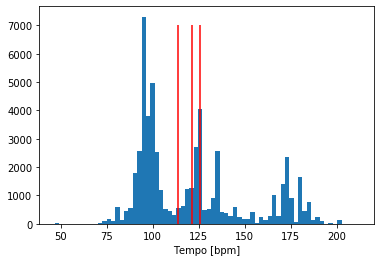

In [49]:
tempo_min = complete_df["tempo"].min()
tempo_max = complete_df["tempo"].max()

tempo_bins = bins_list(tempo_min, tempo_max, 70)

complete_mean = complete_df["tempo"].mean()
complete_mode = complete_df["tempo"].mode()
complete_median = complete_df["tempo"].median()


tempo_category = pd.cut(complete_df["tempo"], bins = tempo_bins)
complete_df["Tempo Category"] = tempo_category
plt.hist(complete_df["tempo"], tempo_bins)
plt.xlabel("Tempo [bpm]")
#plt.ylabel("Appearances in Top 50 Chart")
plt.vlines(complete_mean, 0, 7000, color = "red")
plt.vlines(complete_mode, 0, 7000, color = "red")
plt.vlines(complete_median, 0, 7000, color = "red")
#plt.text(125,4000,f"Mode: {round(complete_mean,2)} bpm ", color = "red", size = "large")
plt.show()

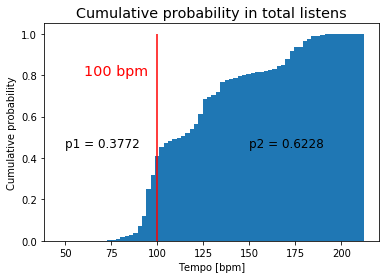

In [13]:
complete_df["Tempo Category"] = tempo_category
plt.hist(complete_df["tempo"], tempo_bins, cumulative = True, density = True)
plt.xlabel("Tempo [bpm]")
plt.ylabel("Cumulative probability")
p_less_100 = complete_df["tempo"].loc[complete_df["tempo"] < 100].count() / complete_df["Track Name"].count()
p_more_100 = complete_df["tempo"].loc[complete_df["tempo"] > 100].count() / complete_df["Track Name"].count()
plt.vlines(100, 0, 1, color = "red")
plt.text(150, 0.45, f"p2 = {round(p_more_100,4)}", size = "large")
plt.text(50, 0.45, f"p1 = {round(p_less_100,4)}", size = "large")
plt.text(60, 0.8, "100 bpm", c = "red", size = "x-large")
plt.title("Cumulative probability in total listens", size = "x-large")
plt.show()

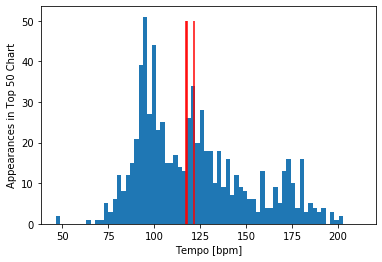

In [48]:
unique_df = complete_df.drop_duplicates(subset = "id")
unique_df = unique_df[["Track Name", "tempo", "Tempo Category", "Genre"]]
unique_mode = unique_df["tempo"].mode()
unique_median = unique_df["tempo"].median()
unique_mean = unique_df["tempo"].mean()

plt.hist(unique_df["tempo"], tempo_bins)
plt.xlabel("Tempo [bpm]")
plt.ylabel("Appearances in Top 50 Chart")
plt.vlines(unique_mode, 0, 50, color = "red")
plt.vlines(unique_median, 0, 50, color = "red")
plt.vlines(unique_mean, 0, 50, color = "red")
#plt.text(125,150,f"Mode: {round(unique_mode,2)} bpm", color = "red", size = "large")
plt.show()

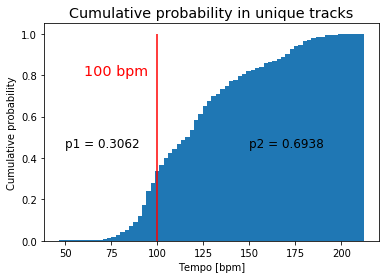

In [14]:
unique_df["Tempo Category"] = tempo_category
plt.hist(unique_df["tempo"], tempo_bins, cumulative = True, density = True)
plt.xlabel("Tempo [bpm]")
plt.ylabel("Cumulative probability")
p_less_100 = unique_df["tempo"].loc[unique_df["tempo"] < 100].count() / unique_df["Track Name"].count()
p_more_100 = unique_df["tempo"].loc[unique_df["tempo"] > 100].count() / unique_df["Track Name"].count()
plt.vlines(100, 0, 1, color = "red")
plt.text(150, 0.45, f"p2 = {round(p_more_100,4)}", size = "large")
plt.text(50, 0.45, f"p1 = {round(p_less_100,4)}", size = "large")
plt.text(60, 0.8, "100 bpm", c = "red", size = "x-large")
plt.title("Cumulative probability in unique tracks", size = "x-large")
plt.show()

In [8]:
stats.ttest_ind(complete_df["tempo"], unique_df["tempo"])

Ttest_indResult(statistic=-0.20843171986979858, pvalue=0.8348926451421976)

Our hypothesis test indicates that there is no difference between the mean value observed in a complete data set (containing all appearances in the Top 50 charts of a given song in the last three years) and the mean value observed in the set containing the unique values of songs. Since p > 0.05 for this test, we can thus accept our null hypothesis and consider that both distributions are similar. Then, tempo is a relevant factor for the popularity of a song.

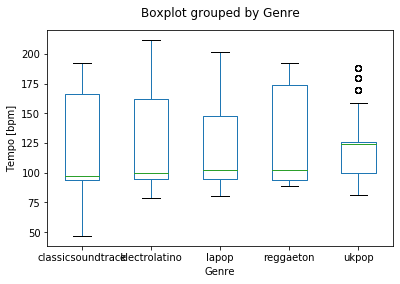

In [55]:
unique_df.head()
#unique_df.boxplot("tempo", by = "Genre")

#unique_df["Genre"].value_counts()
#print(complete_df["Genre"].value_counts())

most_popular_df = complete_df.loc[(complete_df["Genre"] == "lapop") |
                                  (complete_df["Genre"] == "electrolatino") |
                                  (complete_df["Genre"] == "classicsoundtrack") |
                                  (complete_df["Genre"] == "ukpop") |
                                  (complete_df["Genre"] == "reggaeton"),:]

plot = most_popular_df.boxplot("tempo", by = "Genre", grid = False)
plot.set_ylabel("Tempo [bpm]")
plot.set_title("")
plot

## If the chooses to release a reggaeton song, then it will remain in the Top 50 Chart throughout the next year.

## If a song has a higher level of energy, then it will be more likely to be in the Top 50 throughout the next year.

## If a song has a higher level of danceability, then it will be more likely to be in the Top 50 throughout the next year.